<a href="https://colab.research.google.com/github/KreativKrish/FrostHack_2023/blob/root/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import seaborn as sns

color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"


In [9]:
!unzip /content/drive/MyDrive/Brain_tumour/archive.zip

In [10]:
#get the data from
ROOT_DIR = "/content/Brain_tumor"

In [38]:
num_of_images = {}
for dir in os.listdir(ROOT_DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))


In [12]:
num_of_images.items()

dict_items([('yes', 1500), ('no', 1500)])

#We will split the data such that 
  * 70% for training data 
  * 15% for testing data 
  * 15% for Validation

In [13]:
# create a training folder 
def data_folder(p,split):

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)
    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)

      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR,dir)),
                                  size = math.floor(split*num_of_images[dir]),
                                  replace = False):
        O = os.path.join(ROOT_DIR,dir,img)
        D = os.path.join("./"+p,dir)
        shutil.copy(O,D)
        os.remove(O)
    else:
      print(f"{p} folder exists")

In [14]:
data_folder("train",0.7)  


train folder exists


In [15]:
data_folder("val",0.15)

val folder exists


In [16]:
data_folder("test",0.15)

test folder exists


In [17]:
num_of_images = {}
for dir in os.listdir("/content/train"):
  num_of_images[dir] = len(os.listdir(os.path.join("/content/train",dir)))

num_of_images.items()

dict_items([('yes', 1050), ('no', 1050)])

# Model Building

In [18]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten , Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import keras 


In [19]:
# CNN Model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3),activation = 'relu', input_shape = (256,256,3), padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 36, kernel_size = (3,3),activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(64,activation = "relu"))
model.add(Dropout(rate = 0.25))
model.add(Dense(1,activation = "sigmoid"))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 36)      5220      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 36)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        20800     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [20]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ["accuracy"])

Preparing our data using Data Generator 

In [21]:
def preprocessingImages1(path):
  """ 
  input : Path 
  Output : Preprocessed images 
  """
  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range=0.2, rescale = 1/255,horizontal_flip=True)
  image = image_data.flow_from_directory(directory= path, target_size=(256,256),batch_size = 32,class_mode='binary')

  # image_dataset_from_directory(directory=path,batch_size= 32,image_size=(224,224),shuffle = True,)


  return image





In [22]:
path = "/content/train"
train_data = preprocessingImages1(path)

Found 2100 images belonging to 2 classes.


In [23]:
def preprocessingImages2(path):
  """ 
  input : Path 
  Output : Preprocessed images 
  """
  image_data = ImageDataGenerator(rescale = 1/255)
  image = image_data.flow_from_directory(directory= path, target_size=(256,256),batch_size = 32,class_mode='binary')

  # image_dataset_from_directory(directory=path,batch_size= 32,image_size=(224,224),shuffle = True,)


  return image


In [24]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 450 images belonging to 2 classes.


In [25]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 450 images belonging to 2 classes.


In [26]:
# early stopping and model check point 

from keras.callbacks import  ModelCheckpoint, EarlyStopping

#early stopping 

es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 8,verbose = 1,mode = 'auto')

#model checkpoint
mc = ModelCheckpoint(monitor = "val_accuracy", filepath= "./bestmodel.h5",verbose = 1,save_best_only=True,mode = 'auto')

cd = [es,mc]

In [27]:
STEPS_PER_EPOCH = 2100//32

VALIDATION_STEPS = 450//32 # if you have validation data 

In [28]:
print(STEPS_PER_EPOCH)
print(VALIDATION_STEPS)

65
14


# Training the model

In [29]:
hs = model.fit_generator(generator = train_data,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         epochs=40,
                         verbose = 1,
                         validation_data = val_data,
                         validation_steps=VALIDATION_STEPS,
                         callbacks = cd)


Epoch 1/40
65/65 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.6978
Epoch 1: val_accuracy improved from -inf to 0.84152, saving model to ./bestmodel.h5
65/65 [==============================] - 51s 564ms/step - loss: 0.5747 - accuracy: 0.6978 - val_loss: 0.4197 - val_accuracy: 0.8415
Epoch 2/40
65/65 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8071
Epoch 2: val_accuracy improved from 0.84152 to 0.85714, saving model to ./bestmodel.h5
65/65 [==============================] - 38s 579ms/step - loss: 0.4443 - accuracy: 0.8071 - val_loss: 0.3260 - val_accuracy: 0.8571
Epoch 3/40
65/65 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.8366
Epoch 3: val_accuracy did not improve from 0.85714
65/65 [==============================] - 39s 602ms/step - loss: 0.3843 - accuracy: 0.8366 - val_loss: 0.3396 - val_accuracy: 0.8549
Epoch 4/40
65/65 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8457
Epoch 

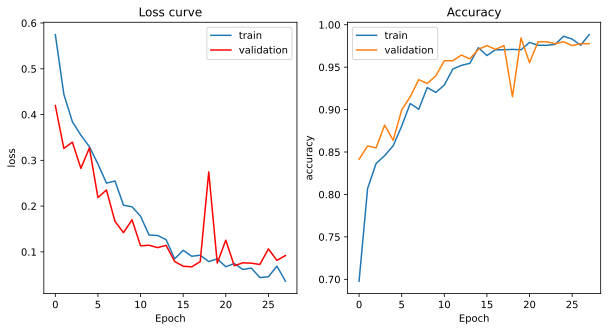

In [30]:
#get the training and validation accuracy
train_acc = hs.history['accuracy']
valid_acc = hs.history['val_accuracy']

#get the loss
train_loss = hs.history['loss']
valid_loss = hs.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss,c = "red")
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [31]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
# Model Accuracy 
from keras.models import load_model

best_model = load_model("/content/bestmodel.h5")


# Model Accuracy 

In [33]:
acc  = model.evaluate_generator(test_data)[1]
print(f"the accuracy of the model is {round(acc*100,3)}%")

the accuracy of the model is 98.222%


In [34]:
train_data.class_indices

{'no': 0, 'yes': 1}

In [35]:
from tensorflow.keras.utils import load_img, img_to_array


1/1 [==============================] - 0s 60ms/step
The MRI is having Tumor


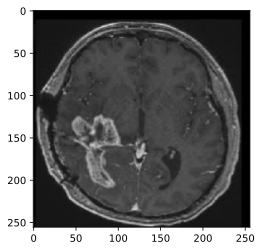

In [55]:
path = "/content/pred/pred13.jpg"

img = load_img(path,target_size = (256,256))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show

input_arr = np.expand_dims(input_arr,axis = 0)
predict_x = (best_model.predict(input_arr)[0][0] > 0.5).astype("int32")

if predict_x == 1:
  print("The MRI is having Tumor")
else:
  print("The MRI is not having a Tumor")

In [45]:
predict_x

0